## Potential issues in the `rutgers_nw_production_raw.csv` reference file

The aim of the task was to replicate the output found in `data/raw/rutgers_nw_production_raw.csv`, for crop yield losses (in percentage points) at the country level in the event of a 150Tg soot emission nuclear winter scenario, as modelled in the [Xia et al. (2022)](https://www.nature.com/articles/s43016-022-00573-0) study.

In inspecting this file, I noticed some irregularities suggestive of the fact that several columns seem to have been produced from either different code or different data sources. This is why I split the evaluation metrics for `soy` and `spring_wheat` in `src/2_model_evaluation.py` into `All years` and `Years 6 - 10` for soy and `Years 5-10` for spring wheat, since I have reason to believe the preceding years may not be valid or correct data to compare to.

In particular, some columns, after excluding for values > 1E+035 (presumably because the source code that produced this file followed the [NUG conventions](http://cfconventions.org/cf-conventions/v1.6.0/cf-conventions.html#missing-data) such that _the default \_FillValue is very close to the maximum representable value of IEEE single precision floats_), which represent NaNs, have a much lower significant figure representation (3 significant figures) compared to all other columns, as seen from the code below.

In [3]:
import pandas as pd
import numpy as np

In [11]:
# Load the CSV file
file_path = '../data/raw/rutgers_nw_production_raw.csv'
df = pd.read_csv(file_path)

# Filter out columns "ISO3 Country Code" and "Country"
filtered_df = df.drop(columns=["ISO3 Country Code", "Country"], errors='ignore')

# Replace NaN placeholder values (greater than 1E+035) with actual NaN
filtered_df = filtered_df.applymap(lambda x: None if x > 1e35 else x)

# Function to count the number of significant figures
def count_significant_figures(value):
    if isinstance(value, (int, float)) and not np.isnan(value):
        value_str = f"{value:.15g}".replace('.', '').replace('-', '').lstrip('0')  # Remove decimal, negative sign, and leading zeros
        return len(value_str)
    return 0

# Identify high and low precision columns based on significant figures
high_precision_cols = []
low_precision_cols = []

for col in filtered_df.columns:
    if filtered_df[col].dtype in ['float64', 'float32']:
        # Filter out values greater than 1E+035 or values with "E" in them
        filtered_values = filtered_df[col].dropna()
        filtered_values = filtered_values[filtered_values.apply(lambda x: 'E' not in str(x) and x <= 1e35)]

        # Convert values to strings and count the number of significant figures
        max_significant_figures = filtered_values.apply(count_significant_figures).max()

        # Classify based on significant figures
        if max_significant_figures <= 4:
            low_precision_cols.append(col)
        else:
            high_precision_cols.append(col)

# Print out the results
print("High Precision Columns:", high_precision_cols)
print()
print("Low Precision Columns:", low_precision_cols)


High Precision Columns: ['corn_year1', 'corn_year2', 'corn_year3', 'corn_year4', 'corn_year5', 'corn_year6', 'corn_year7', 'corn_year8', 'corn_year9', 'corn_year10', 'rice_year1', 'rice_year2', 'rice_year3', 'rice_year4', 'rice_year5', 'rice_year6', 'rice_year7', 'rice_year8', 'rice_year9', 'rice_year10', 'soy_year6', 'soy_year7', 'soy_year8', 'soy_year9', 'soy_year10', 'spring_wheat_year5', 'spring_wheat_year6', 'spring_wheat_year7', 'spring_wheat_year8', 'spring_wheat_year9', 'spring_wheat_year10', 'grasses_year1', 'grasses_year2', 'grasses_year3', 'grasses_year4', 'grasses_year5', 'grasses_year6', 'grasses_year7', 'grasses_year8', 'grasses_year9', 'grasses_year10']

Low Precision Columns: ['soy_year1', 'soy_year2', 'soy_year3', 'soy_year4', 'soy_year5', 'spring_wheat_year1', 'spring_wheat_year2', 'spring_wheat_year3', 'spring_wheat_year4']


/tmp/ipykernel_7583/383575517.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  filtered_df = filtered_df.applymap(lambda x: None if x > 1e35 else x)


This is also somewhat visible if we plot the contents of these files (as a spaghetti plot for each crop across time, with each country forming one "strand"), where the soy and spring wheat plots show erratic behaviour in those years which belong to low precision columns, relative to other years for the same crop and all years for other crops.

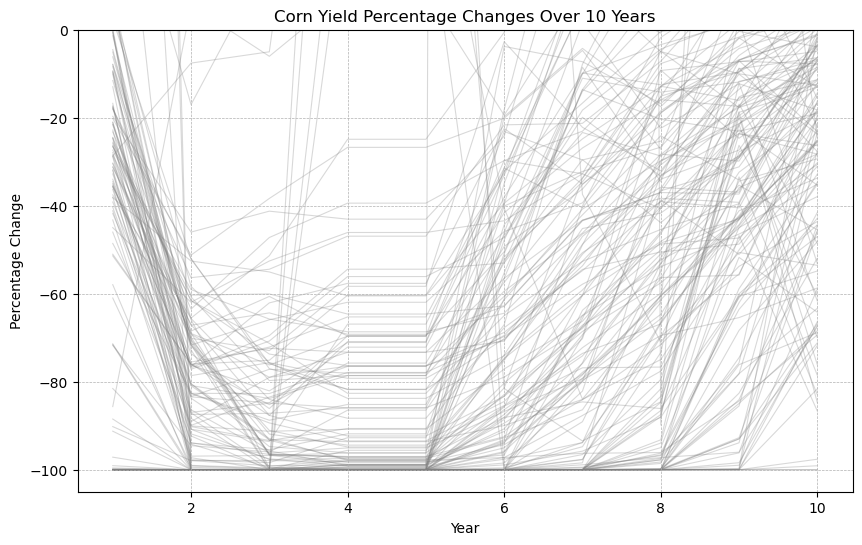

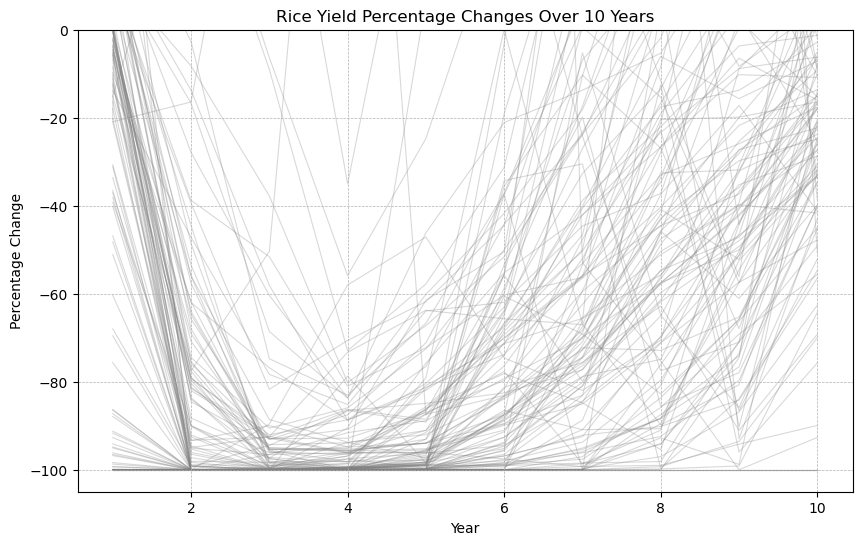

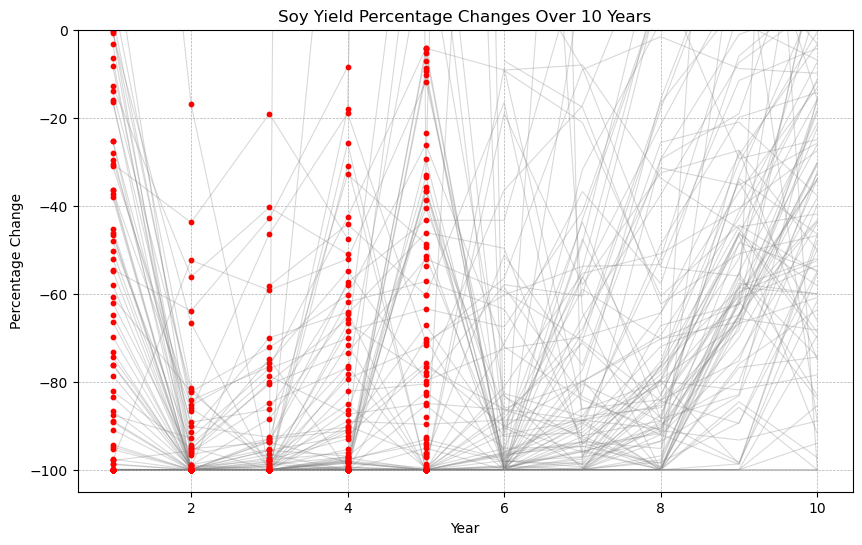

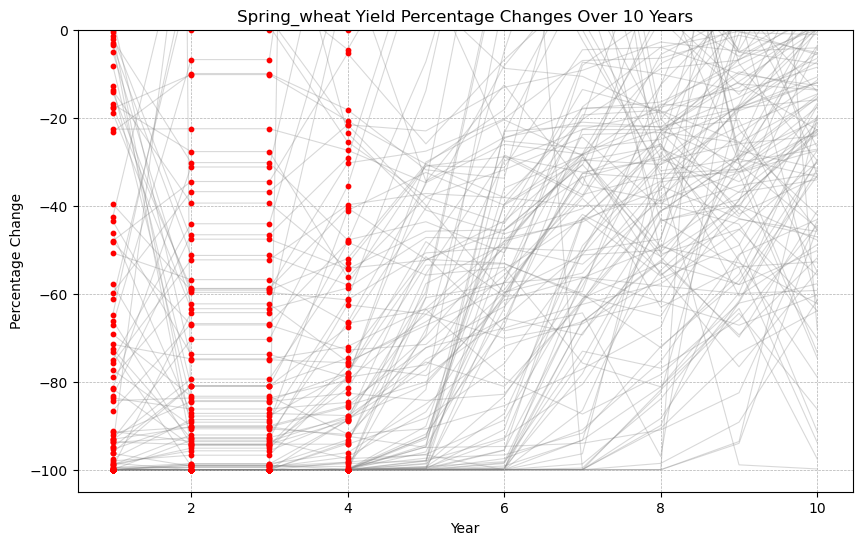

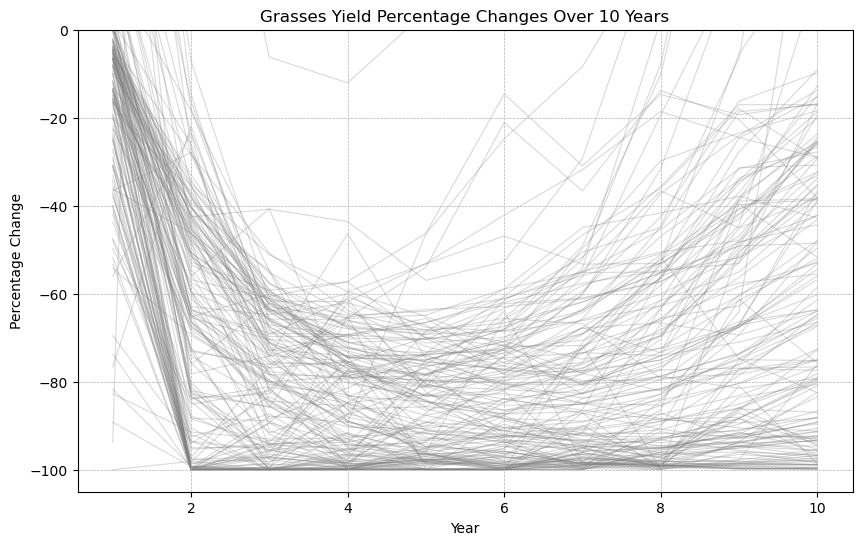

In [13]:
import matplotlib.pyplot as plt

# Define crop groups and their respective columns
crop_groups = {
    'corn': [f'corn_year{i}' for i in range(1, 11)],
    'rice': [f'rice_year{i}' for i in range(1, 11)],
    'soy': [f'soy_year{i}' for i in range(1, 11)],
    'spring_wheat': [f'spring_wheat_year{i}' for i in range(1, 11)],
    'grasses': [f'grasses_year{i}' for i in range(1, 11)],
}

# Iterate through each crop group to create a spaghetti plot
for crop, columns in crop_groups.items():
    plt.figure(figsize=(10, 6))
    plt.title(f'{crop.capitalize()} Yield Percentage Changes Over 10 Years')
    plt.xlabel('Year')
    plt.ylabel('Percentage Change')
    plt.grid(True, linestyle='--', linewidth=0.5)

    # Extract time series data for the crop
    crop_data = filtered_df[columns]
    years = list(range(1, 11))

    # Plot each country's time series
    for index, row in crop_data.iterrows():
        # Identify the color for each point in the series (grey or red)
        line_colors = ['grey'] * len(years)
        
        for i, col in enumerate(columns):
            if col in low_precision_cols:
                if not pd.isna(row[col]):
                    line_colors[i] = 'red'

        # Plot the line for this country
        plt.plot(years, row.values, color='grey', alpha=0.3, linewidth=0.8, zorder=1)
        
        # Overlay red points where precision is low
        for i, col in enumerate(columns):
            if col in low_precision_cols and not pd.isna(row[col]):
                plt.scatter(years[i], row[col], color='red', s=10, zorder=2)

    plt.ylim([-105, 0])
    plt.show()


This is why I report on two different accuracy metrics for these crops, and may explain some of the discrepancy between my results and those from the reference file.